# Hands-on: Spatial interpolation methods at work

### Master<br>...

<br>
<b style="font-family:Fantasy">Giuliano Langella</b> &nbsp; &nbsp;
<b style="font-family:Arial">glangella@unina.it</b>

<b>Tobler's Low of Geography (1970): <br><em>$\quad$ "Everything is related to everything else, but near things are more related than distant things".</em></b>

---

## Mean Soil Temperature | Campania Region (IT)

Models of interpolation used in this study:
 - NULL model
 - Proximity polygons (Thiessen or Voronoi)
 - Nearest neighbour
 - Inverse Distance Weighted
 - Linear Model (regression)
 - Kriging

### R objects that must be created

| Name  | Data Model | Class                 | Created From   | NOTES               |
|:------|:-----------|:----------------------|:---------------|:--------------------|
|tmean  | vector     | DataFrame             | csv file       | 493 rec. x 3 var.   |
|tm_sf  | vector     | SimpleFeature         | dataframe      | T mean geodata (SF) |
|tm_sp  | vector     | SpatialPointDataFrame | dataframe      | T mean geodata (SP) |
|ca_rl  | raster     | RasteLayer            | scratch        | 100m, empty, charts |
|ca_sp  | raster     | SpatialPixels         | scratch        | 100m, empty, gstat  |
|ca_dem | raster     | RasteLayer            | tif file       | 20m, dem, regression|
|ca_pol | vector     | SimpleFeature         | geojson file   | admin limits, mask  |

### Import Soil Temperature measurements

In [1]:
getwd()

[1] "/home/jovyan/work/Didattica/Veterinaria/PrecisionLivestockFarming/lectures/2021"

In [2]:
setwd('/home/jovyan/work/Didattica/esercizi/DTA/')

In [3]:
dir()

[1] "dem_campania.tif"                          
 [2] "dem_campania.tif.zip"                      
 [3] "dta_explanation_examples.qgz"              
 [4] "ElevTemp.cpg"                              
 [5] "ElevTemp.dbf"                              
 [6] "ElevTemp.prj"                              
 [7] "ElevTemp.qpj"                              
 [8] "ElevTemp.shp"                              
 [9] "ElevTemp.shx"                              
[10] "ElevTempData.qgz"                          
[11] "log-file-gdal-commands.txt"                
[12] "slope-aspect__differenzeElementiFiniti.jpg"
[13] "XY_Tmean.csv"

In [4]:
library(readr)
tmean <- read_csv("XY_Tmean.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  Xcoord = col_double(),
  Ycoord = col_double(),
  Tmean = col_double()
)




In [5]:
class(tmean)

[1] "spec_tbl_df" "tbl_df"      "tbl"         "data.frame"

### Create the reference vector data model

In [6]:
names(tmean)

[1] "Xcoord" "Ycoord" "Tmean"

In [89]:
dim(tmean)

[1] 493   3

#### SF

In [7]:
require(sf)

Loading required package: sf

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1



In [8]:
tm_sf <- st_as_sf(tmean,coords=c('Xcoord','Ycoord'),crs=32633)

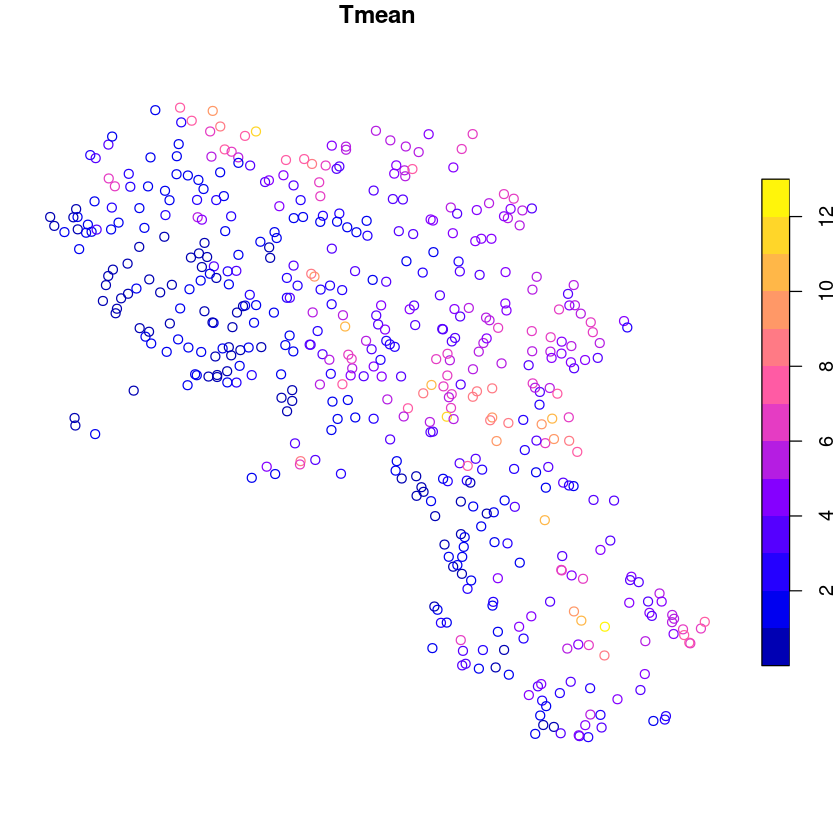

In [115]:
plot(tm_sf)

##### advanced plot

In [114]:
require(RColorBrewer)

Loading required package: RColorBrewer



In [117]:
myPalette <- brewer.pal(7,'OrRd')

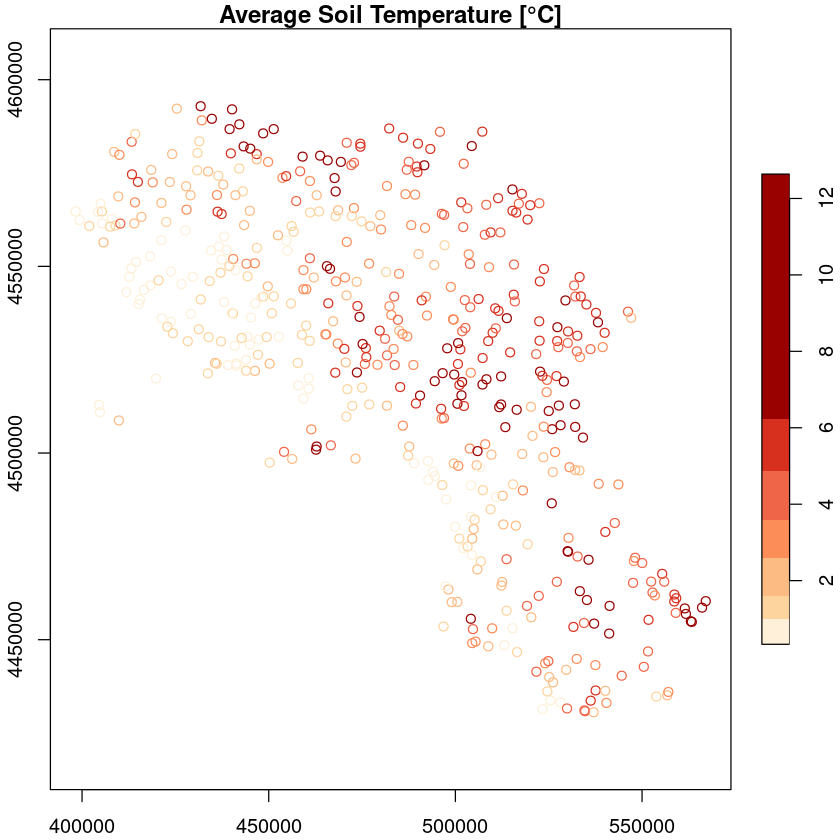

In [126]:
plot(tm_sf,
     main='Average Soil Temperature [°C]',
     breaks='quantile', nbreaks=7,
     pal=myPalette,
     axes=TRUE #,
#     xlab='Easting [m]',
#     ylab='Northing [m]'     
    )

##### tmap plot

#### SPDF

In [10]:
require(sp)

Loading required package: sp



In [11]:
tm_sp <- as_Spatial(tm_sf)

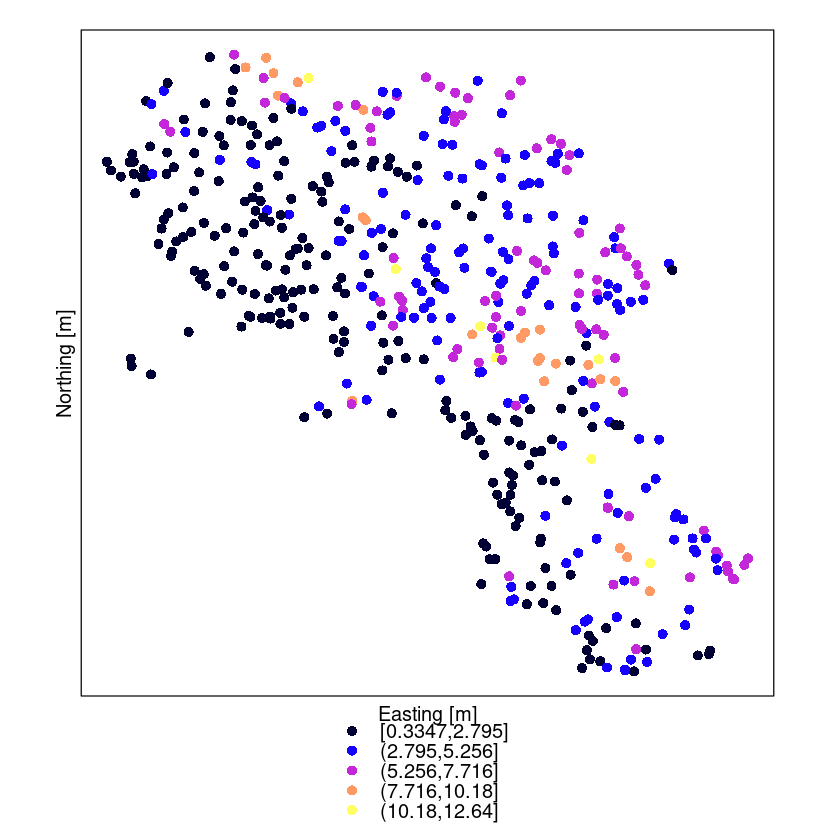

In [128]:
spplot( tm_sp,
        zcol='Tmean',
        xlab='Easting [m]',
        ylab='Northing [m]'
      )

### Create the reference raster for interpolations

#### RasterLayer

##### From scratch | using the bbox of measurement locations

In [13]:
BB=st_bbox(tm_sf)
BB

   xmin    ymin    xmax    ymax 
 398275 4430586  567061 4592903 

In [14]:
require(raster)
ca_rl <- raster(xmn=BB[1],ymn=BB[2],xmx=BB[3],ymx=BB[4],
                crs=CRS('+init=epsg:32633'),resolution=100
               )
ca_rl

Loading required package: raster



class      : RasterLayer 
dimensions : 1623, 1688, 2739624  (nrow, ncol, ncell)
resolution : 100, 100  (x, y)
extent     : 398275, 567075, 4430603, 4592903  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 


##### From reference raster | using Campania DEM

In [15]:
dir()

[1] "dem_campania.tif"                          
 [2] "dem_campania.tif.zip"                      
 [3] "dta_explanation_examples.qgz"              
 [4] "ElevTemp.cpg"                              
 [5] "ElevTemp.dbf"                              
 [6] "ElevTemp.prj"                              
 [7] "ElevTemp.qpj"                              
 [8] "ElevTemp.shp"                              
 [9] "ElevTemp.shx"                              
[10] "ElevTempData.qgz"                          
[11] "log-file-gdal-commands.txt"                
[12] "slope-aspect__differenzeElementiFiniti.jpg"
[13] "XY_Tmean.csv"

In [16]:
ca_dem <- raster('dem_campania.tif')
ca_rl20 <- ca_dem
hasValues(ca_rl20)

[1] TRUE

In [17]:
values(ca_rl20) <- NA
ca_rl20

class      : RasterLayer 
dimensions : 8433, 8616, 72658728  (nrow, ncol, ncell)
resolution : 20, 20  (x, y)
extent     : 396311.5, 568631.5, 4426983, 4595643  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : dem_campania 
values     : NA, NA  (min, max)


In [18]:
hasValues(ca_rl20)

[1] TRUE

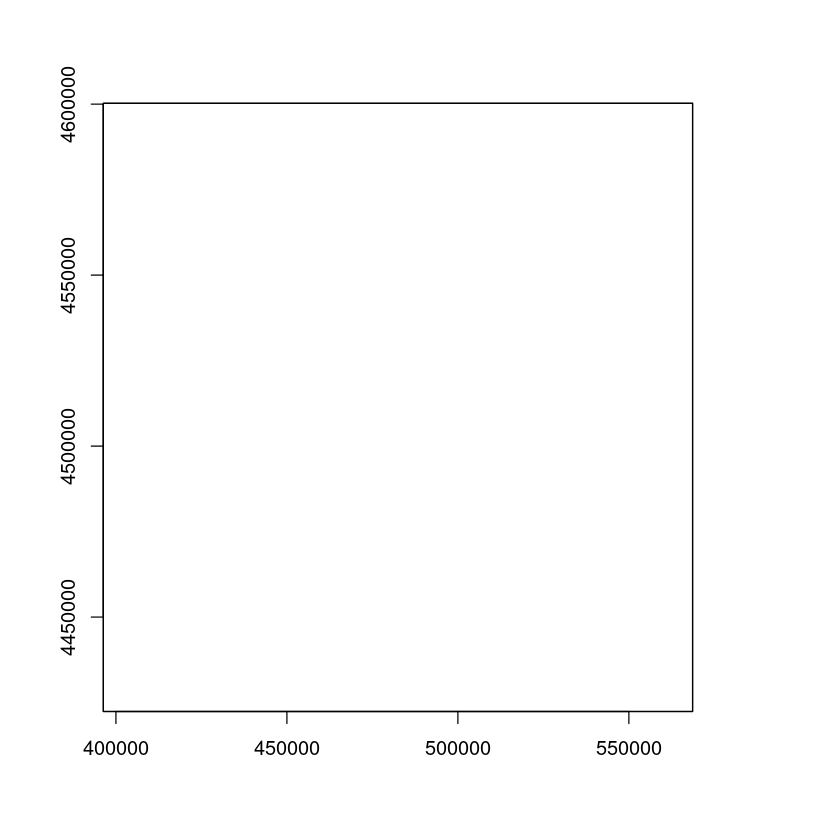

In [19]:
plot(ca_rl20)

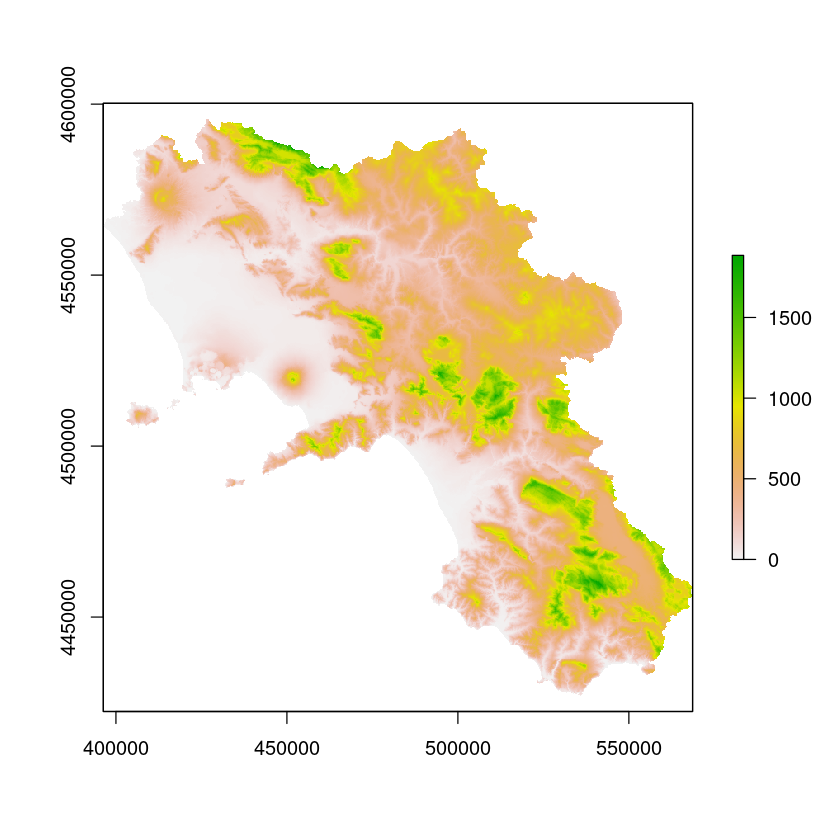

In [20]:
plot(ca_dem)

#### SpatialPixels

In [21]:
ca_sp <- rasterToPoints(ca_rl,spatial=TRUE)
gridded(ca_sp) <- TRUE

In [22]:
summary(ca_sp)

Object of class SpatialPixels
Coordinates:
      min     max
x  398275  567075
y 4430603 4592903
Is projected: TRUE 
proj4string :
[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs]
Number of points: 2739624
Grid attributes:
  cellcentre.offset cellsize cells.dim
x            398325      100      1688
y           4430653      100      1623

### Study Area Multipolygon

In [23]:
ca_pol_gcs <- st_read('../Ca.geojson')

Reading layer `Ca' from data source `/home/jovyan/work/Didattica/esercizi/Ca.geojson' using driver `GeoJSON'
Simple feature collection with 1 feature and 9 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 13.76238 ymin: 39.99052 xmax: 15.80645 ymax: 41.50835
Geodetic CRS:  WGS 84


In [25]:
ca_pol <- st_transform(ca_pol_gcs,32633)
print(ca_pol$geometry)

Geometry set for 1 feature 
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 396265 ymin: 4426789 xmax: 568564.3 ymax: 4595560
Projected CRS: WGS 84 / UTM zone 33N


MULTIPOLYGON (((396265 4564263, 396323.8 456424...



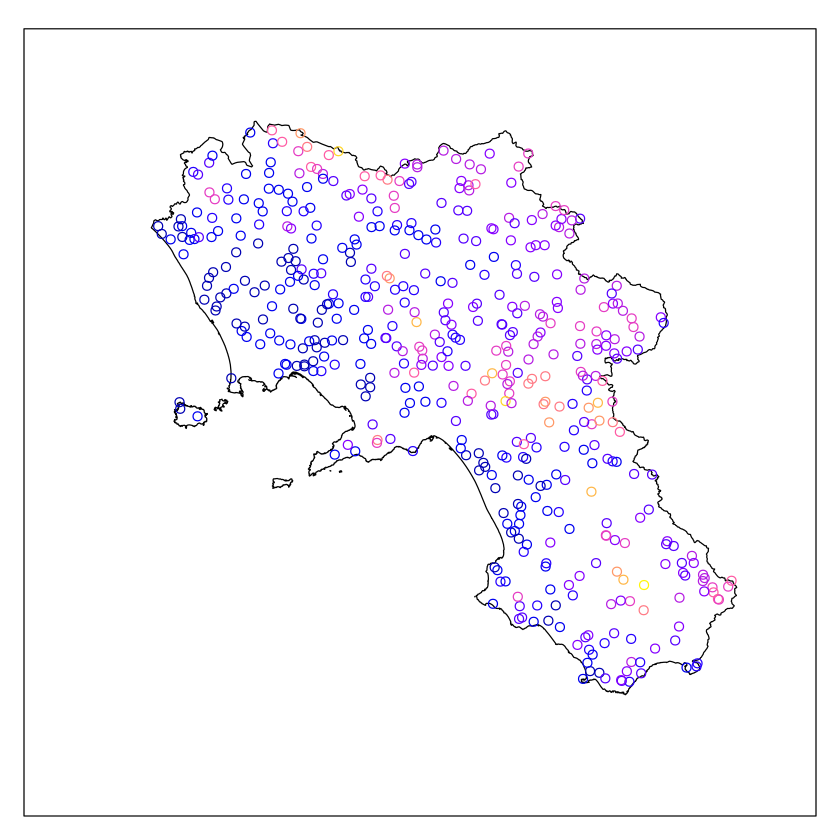

In [26]:
plot(ca_pol$geometry,reset=FALSE)
plot(tm_sf,add=TRUE)
box()

### Recap R objects

In [27]:
ls()

[1] "BB"         "ca_dem"     "ca_pol"     "ca_pol_gcs" "ca_rl"     
 [6] "ca_rl20"    "ca_sp"      "tm_sf"      "tm_sp"      "tmean"

In [28]:
rm(BB,ca_pol_gcs,ca_rl20, tmean)

### Null model

In [29]:
summary(tm_sp)

Object of class SpatialPointsDataFrame
Coordinates:
              min     max
coords.x1  398275  567061
coords.x2 4430586 4592903
Is projected: TRUE 
proj4string :
[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs]
Number of points: 493
Data attributes:
     Tmean        
 Min.   : 0.3347  
 1st Qu.: 1.4522  
 Median : 3.2497  
 Mean   : 3.5548  
 3rd Qu.: 5.0767  
 Max.   :12.6371  

In [30]:
mean(tm_sp$Tmean)

[1] 3.554821

In [31]:
ca_rl_null <- ca_rl

In [32]:
ca_rl_null

class      : RasterLayer 
dimensions : 1623, 1688, 2739624  (nrow, ncol, ncell)
resolution : 100, 100  (x, y)
extent     : 398275, 567075, 4430603, 4592903  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 


In [33]:
hasValues(ca_rl_null)

[1] FALSE

In [35]:
ca_rl_null[1:ncell(ca_rl_null)] <- mean(tm_sp$Tmean)
hasValues(ca_rl_null)

[1] TRUE

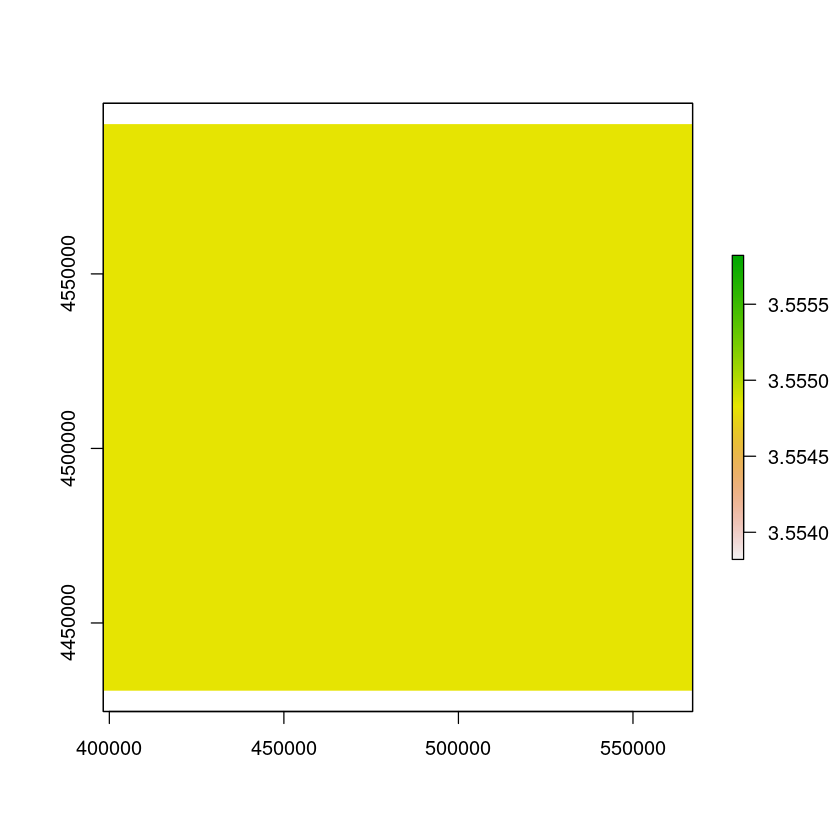

In [36]:
plot(ca_rl_null)

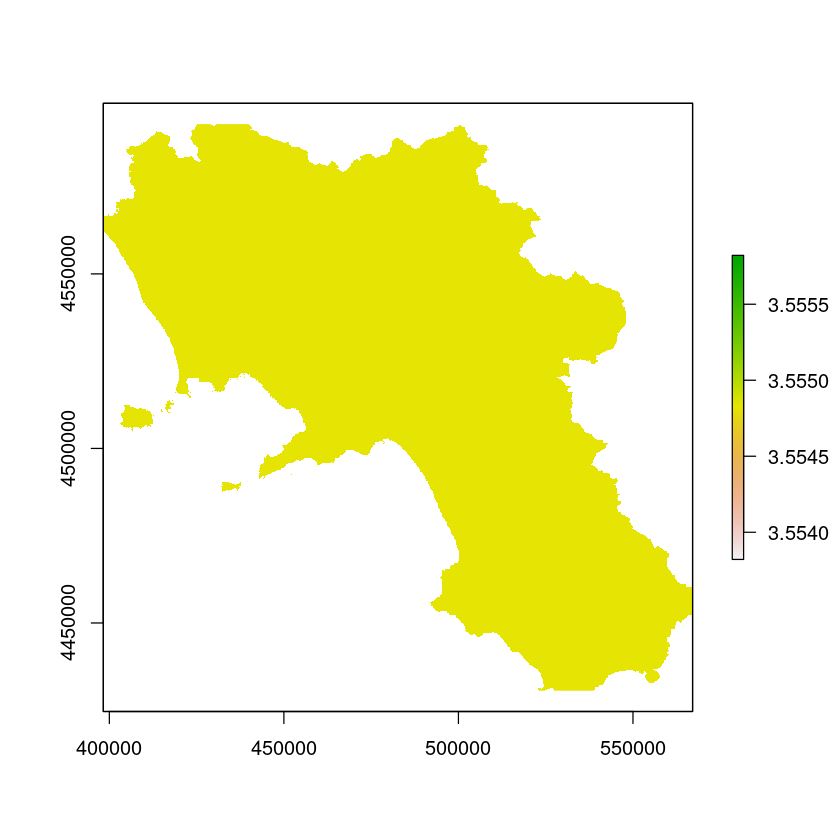

In [37]:
ca_rl_null <- mask(ca_rl_null,ca_pol)
plot(ca_rl_null)

### Proximity polygons (Thiessen or Voronoi)

In [40]:
thie_pol <- st_voronoi( st_union(tm_sf) )

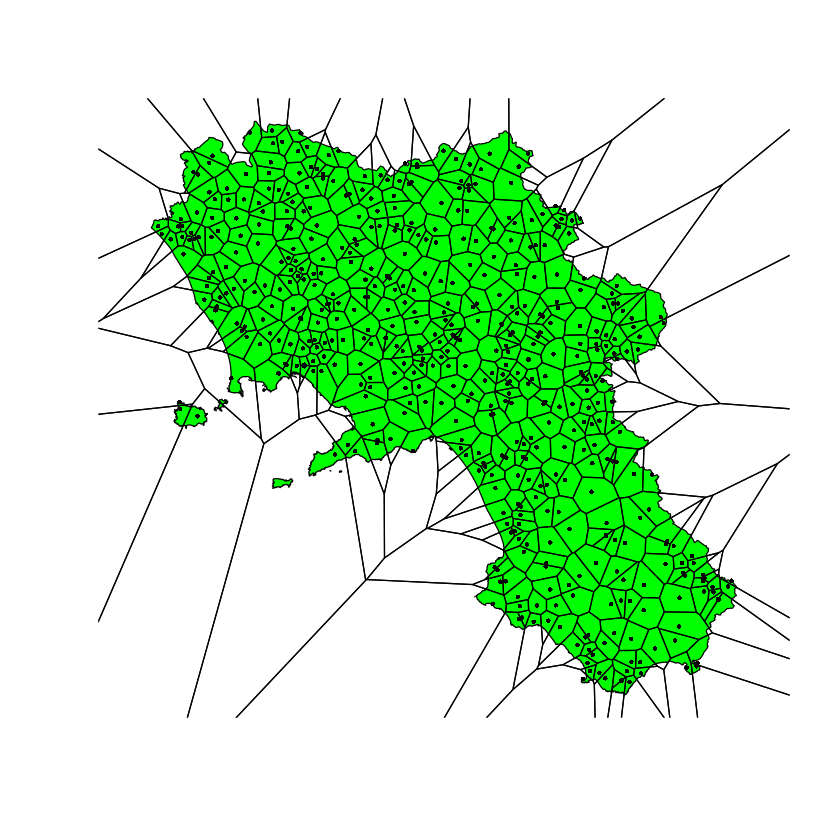

In [67]:
plot(ca_pol$geometry,col='green',reset=FALSE)
plot(thie_pol,col=NA,add=TRUE)
plot(tm_sf,add=TRUE,pch=16,col='black',cex=0.5)

In [68]:
class(thie_pol)

[1] "sfc_GEOMETRYCOLLECTION" "sfc"

In [74]:
require(gstat)

Loading required package: gstat



In [76]:
ca_rl_thie <- idw(Tmean~1,tm_sp,ca_sp,nmax=1)

Warning message in proj4string(d$data):
“CRS object has comment, which is lost in output”


[1] "+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs"


Warning message in proj4string(newdata):
“CRS object has comment, which is lost in output”


[1] "+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs"


ERROR: Error in predict.gstat(g, newdata = newdata, block = block, nsim = nsim, : var1 : data item in gstat object and newdata have different coordinate reference systems


In [77]:
crs(tm_sp)

CRS arguments:
 +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 

In [78]:
crs(ca_sp)

CRS arguments:
 +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 

In [79]:
crs(ca_sp) <- crs(tm_sp)

In [84]:
ca_rl_thie <- idw(Tmean~1,tm_sp,ca_sp,nmax=1)

[inverse distance weighted interpolation]


In [85]:
ca_rl_thie <- raster(ca_rl_thie)
ca_rl_thie <- mask(ca_rl_thie,ca_pol)

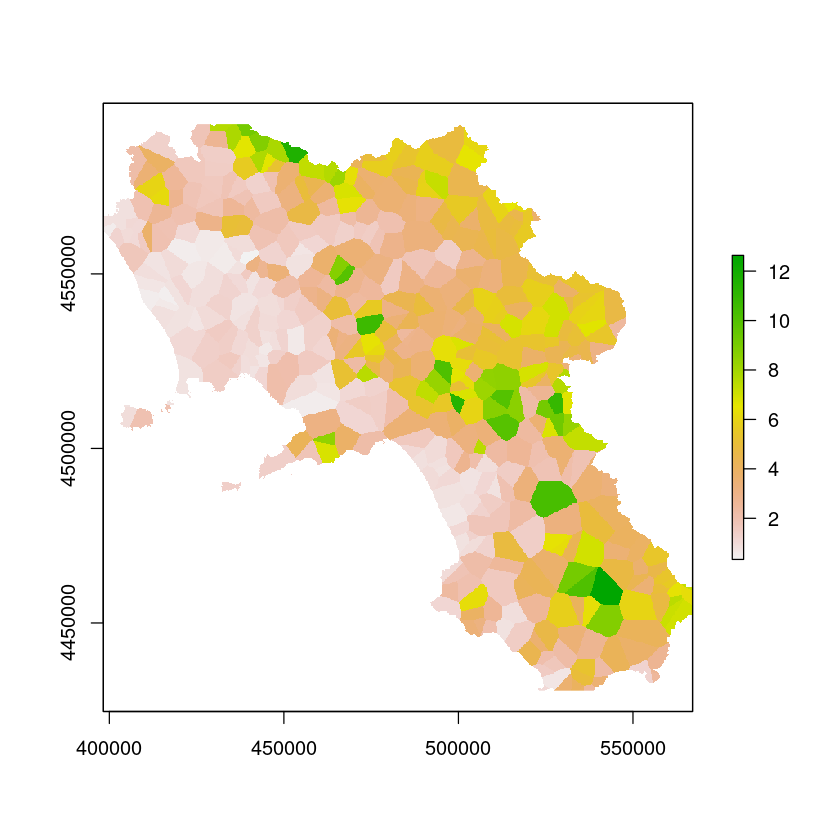

In [86]:
plot(ca_rl_thie)

### Nearest neighbour

In [92]:
ca_rl_nn <- idw(Tmean~1,tm_sp,newdata=ca_sp,idp=0,nmax=3)

[inverse distance weighted interpolation]


In [93]:
ca_rl_nn <- raster(ca_rl_nn)
ca_rl_nn <- mask(ca_rl_nn,ca_pol)

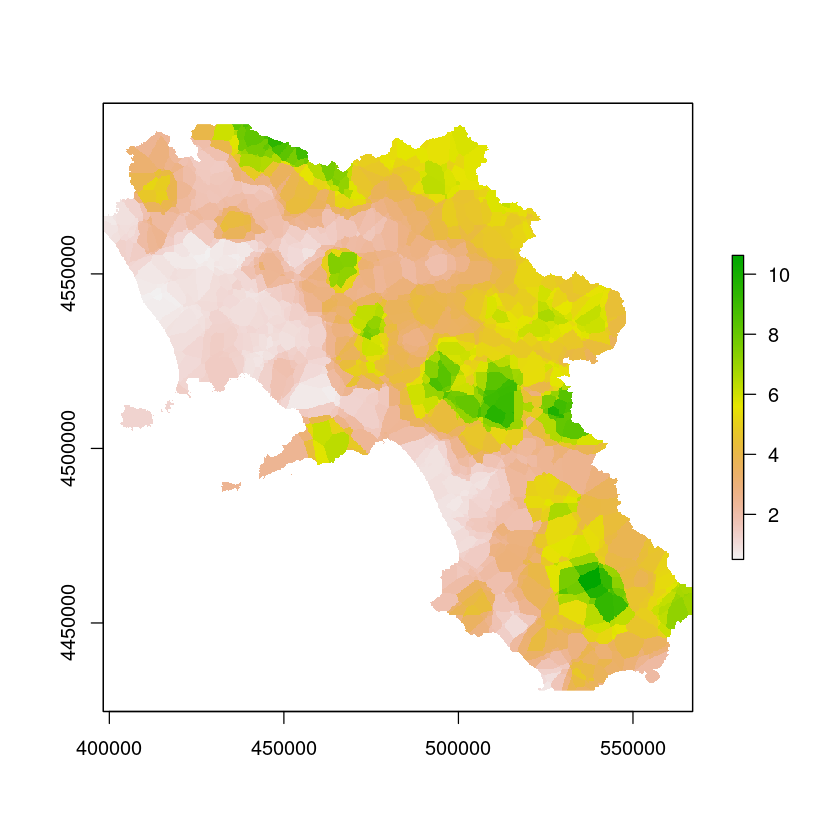

In [94]:
plot(ca_rl_nn)

### Inverse Distance Weighted

Which parameters to use? Think about possible values given to **maxdist**, **nmin** and **nmax**... <br>
We need an interactive **heuristics** approach to learning!<br>
**heuristic:** _enabling someone to discover or learn something for themselves_

In [98]:
ca_rl_idw <- idw(Tmean~1,tm_sp,newdata=ca_sp,idp=2,
    maxdis=12000,nmin=4,nmax=10
   )

[inverse distance weighted interpolation]


In [99]:
ca_rl_idw <- raster(ca_rl_idw)
ca_rl_idw <- mask(ca_rl_idw,ca_pol)

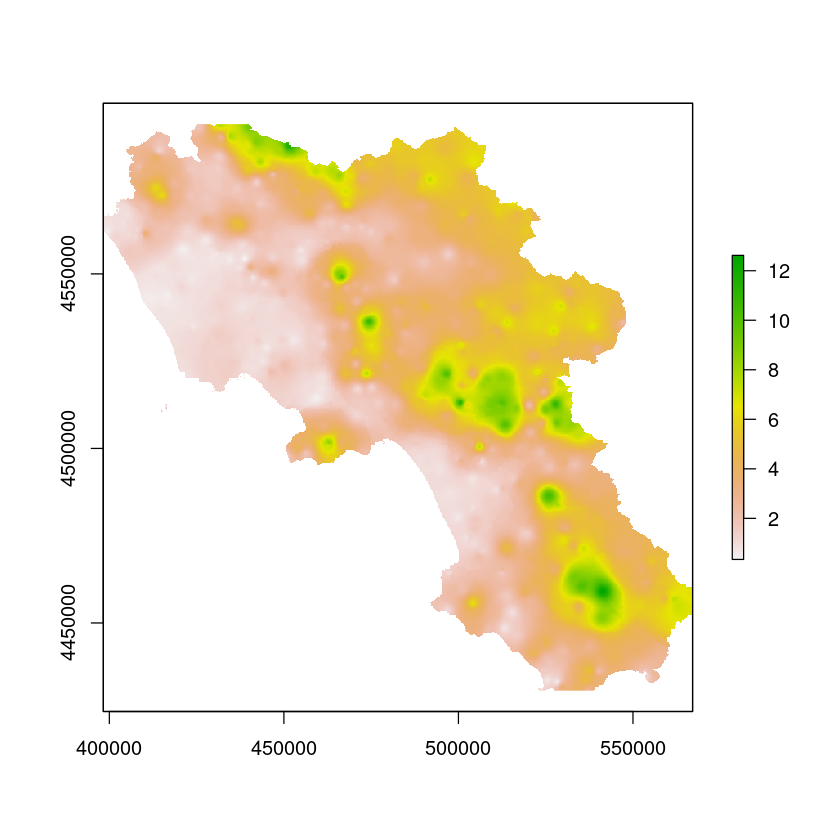

In [100]:
plot(ca_rl_idw)

### Linear Model (regression)

see next lecture...

### Kriging

Which parameters to use? Think about possible values given to **nugget**, **sill**, **range**, **model type**, **maxdist**, **nmin** and **nmax**... <br>
We need an interactive **heuristics** approach to learning!<br>
**heuristic:** _enabling someone to discover or learn something for themselves_

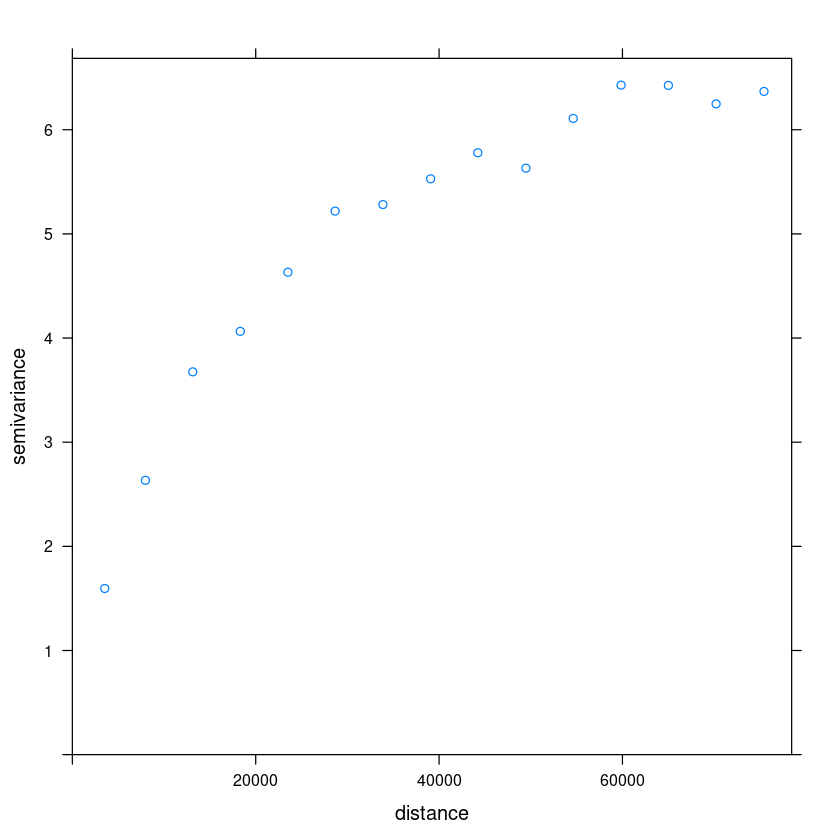

In [101]:
tm.vgm <- variogram(Tmean~1,tm_sp)
plot(tm.vgm)

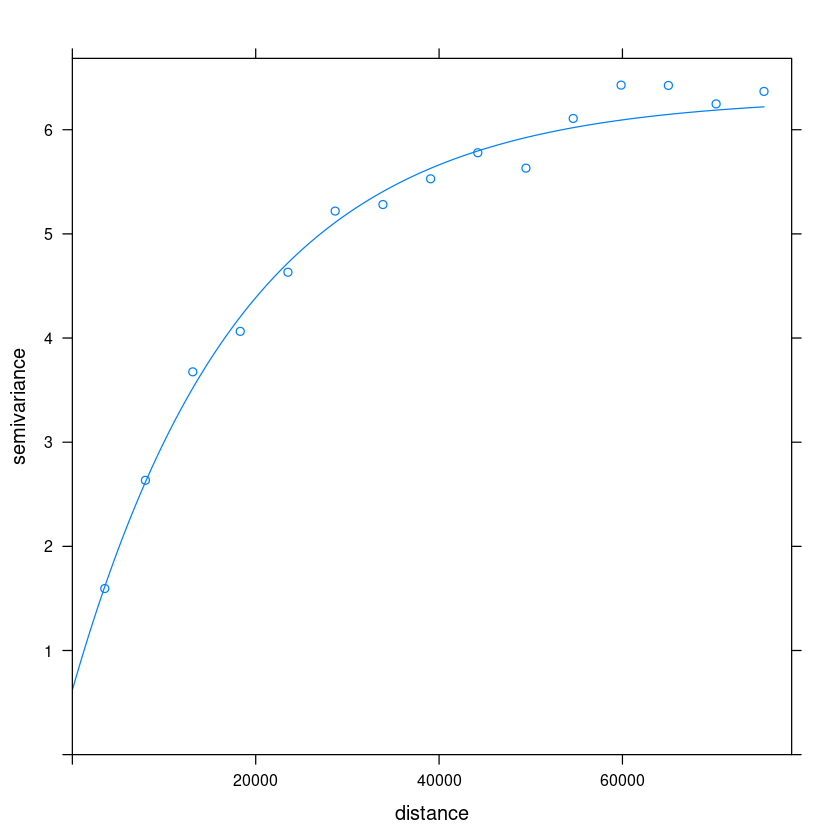

In [105]:
tm.mod <- fit.variogram(tm.vgm,model=vgm(5,'Exp',20000,1))
plot(tm.vgm,tm.mod)

In [106]:
ca_rl_krg <- krige(Tmean~1,tm_sp,model=tm.mod,
                   newdata=ca_sp,
                   maxdist=12000,nmin=4,nmax=10
                  )
summary(ca_rl_krg)

[using ordinary kriging]


Object of class SpatialPixelsDataFrame
Coordinates:
      min     max
x  398275  567075
y 4430603 4592903
Is projected: TRUE 
proj4string :
[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs]
Number of points: 2739624
Grid attributes:
  cellcentre.offset cellsize cells.dim
x            398325      100      1688
y           4430653      100      1623
Data attributes:
   var1.pred          var1.var      
 Min.   : 0.5      Min.   :0.9      
 1st Qu.: 1.9      1st Qu.:1.5      
 Median : 3.5      Median :1.8      
 Mean   : 3.6      Mean   :2.0      
 3rd Qu.: 5.1      3rd Qu.:2.2      
 Max.   :11.3      Max.   :5.2      
 NA's   :1116481   NA's   :1116481  

In [108]:
ca_rl_krg <- raster(ca_rl_krg)
ca_rl_krg <- mask(ca_rl_krg,ca_pol)

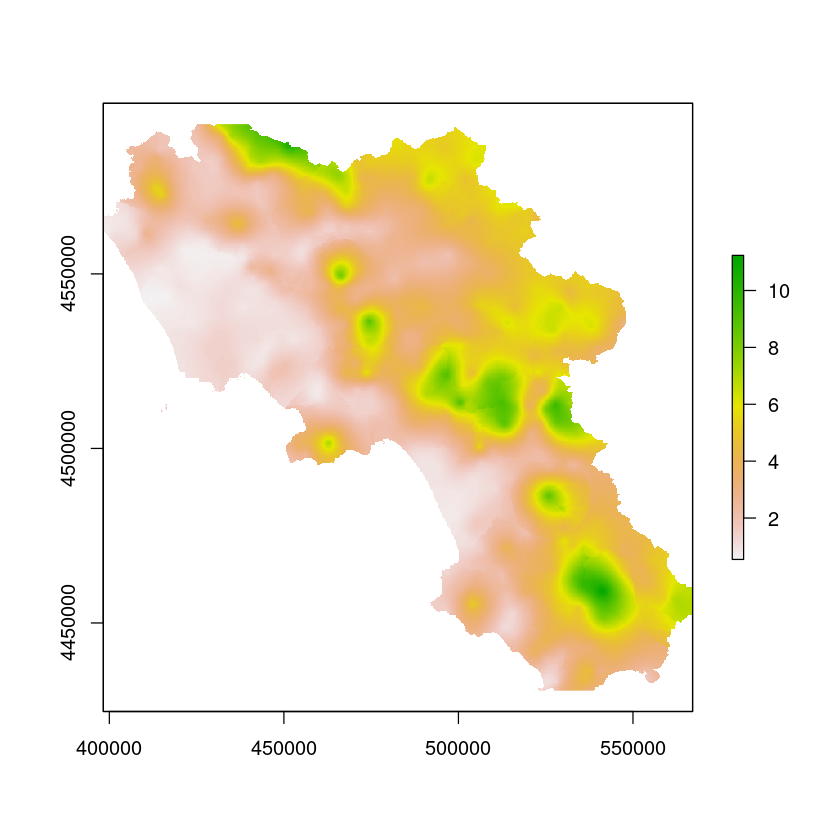

In [109]:
plot(ca_rl_krg)

In [110]:
ca_rl_krg

class      : RasterLayer 
dimensions : 1623, 1688, 2739624  (nrow, ncol, ncell)
resolution : 100, 100  (x, y)
extent     : 398275, 567075, 4430603, 4592903  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=33 +datum=WGS84 +units=m +no_defs 
source     : memory
names      : var1.pred 
values     : 0.5419331, 11.32387  (min, max)
